In [1]:
import pandas as pd
import numpy as np
import os
import csv
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
from datetime import datetime
from collections import Counter
import pickle

In [33]:
DATA_CSV = '../../data/sociology/911_geocoded.csv'#'../../data/sociology/location_geocoded.csv'
POP_PKL = '../../data/sociology/population.pkl'

In [29]:
dframe = pd.read_csv(DATA_CSV)

In [35]:
populations = pickle.load(open(POP_PKL,'rb'))

In [138]:
'''
Constructs time series vector of binned counts from depCol for the indepValue in the indepCol
'''
def binTimes(dframe,indepCol,indepValue,depCol,timeRange):    
    minTime,maxTime = timeRange
    ts = np.zeros(maxTime - minTime + 1)
    
    cnt = Counter(dframe[dframe[indepCol] == indepValue][depCol])
    for key,value in cnt.items():
        ts[key-minTime] = value
    return ts

def addCol(colName = 'week',stringFormat="%m/%d/%Y %I:%M:%S %p"):
    def time2week(dtime, minYear=2015):
        dt = datetime.strptime(dtime,stringFormat)
        return(dt.isocalendar()[1] + (dt.isocalendar()[0]-minYear)*52)
    
    def time2day(dtime, minYear=2015):
        dt = datetime.strptime(dtime,stringFormat)
        return(dt.isocalendar()[2] + dt.isocalendar()[1]*7 + (dt.isocalendar()[0]-minYear)*365)
    
    if colName == 'week':
        func = time2week
    elif colName == 'day':
        func = time2day
    
    dframe[colName] = dframe.apply(lambda x: func(x.callDateTime),axis=1);
    timeRange = (min(dframe[colName]), max(dframe[colName]))
    
    return(dframe,timeRange)

In [ ]:
'''
Constructs time series vector of binned counts from depCol for the indepValue in the indepCol
'''
def binDateTime(dframe,indepCol,indepValue,timeCol):    
    minTime = min(
        dframe[timeCol],
        key=lambda x: datetime.strptime(x, '%m/%d/%Y')
    )
    cnt = Counter(dframe[dframe[indepCol] == indepValue][depCol])
    for key,value in cnt.items():
        ts[key-minTime] = value
    return ts

def addDateResolution(dframe,colName='daily'):
    def convert(dtime,stringTo):
        dt = datetime.strptime(dtime,"%m/%d/%Y %I:%M:%S %p")
        return(dt.strftime(stringTo))
    
    if colName == 'daily':
        stringTo = "%m/%d/%Y"
        func=convert
    
    dframe[colName] = dframe.apply(lambda x: func(x.callDateTime,stringTo),axis=1);

    return(dframe)

In [168]:
def showTimeSeries(tsDict):
    plt.figure(figsize=(20,10))
    plt.xlabel('x', fontsize=15)
    plt.ylabel('y', fontsize=15)
    for key,val in tsDict.items():
        plt.plot(val,label=key)
    plt.legend()

In [179]:
timeRange

(10, 161)

In [170]:
colName = 'week'
dframe,timeRange = addCol(colName)
#dframe = addDateResolution(dframe.copy(),colName)

tsDict = {}
regionCol = 'neighborhood'
normalize=True

for region in set(dframe[regionCol]):
    if normalize:
        pop = populations[populations['name'] == region]['population']
        if pop.empty:
            continue
        pop = pop.iloc[0]
        if not pop == 0:
            tsDict[region] = binTimes(dframe,regionCol,region,colName,timeRange) / pop
    else:
        tsDict[region] = binTimes(dframe,regionCol,region,colName,timeRange)

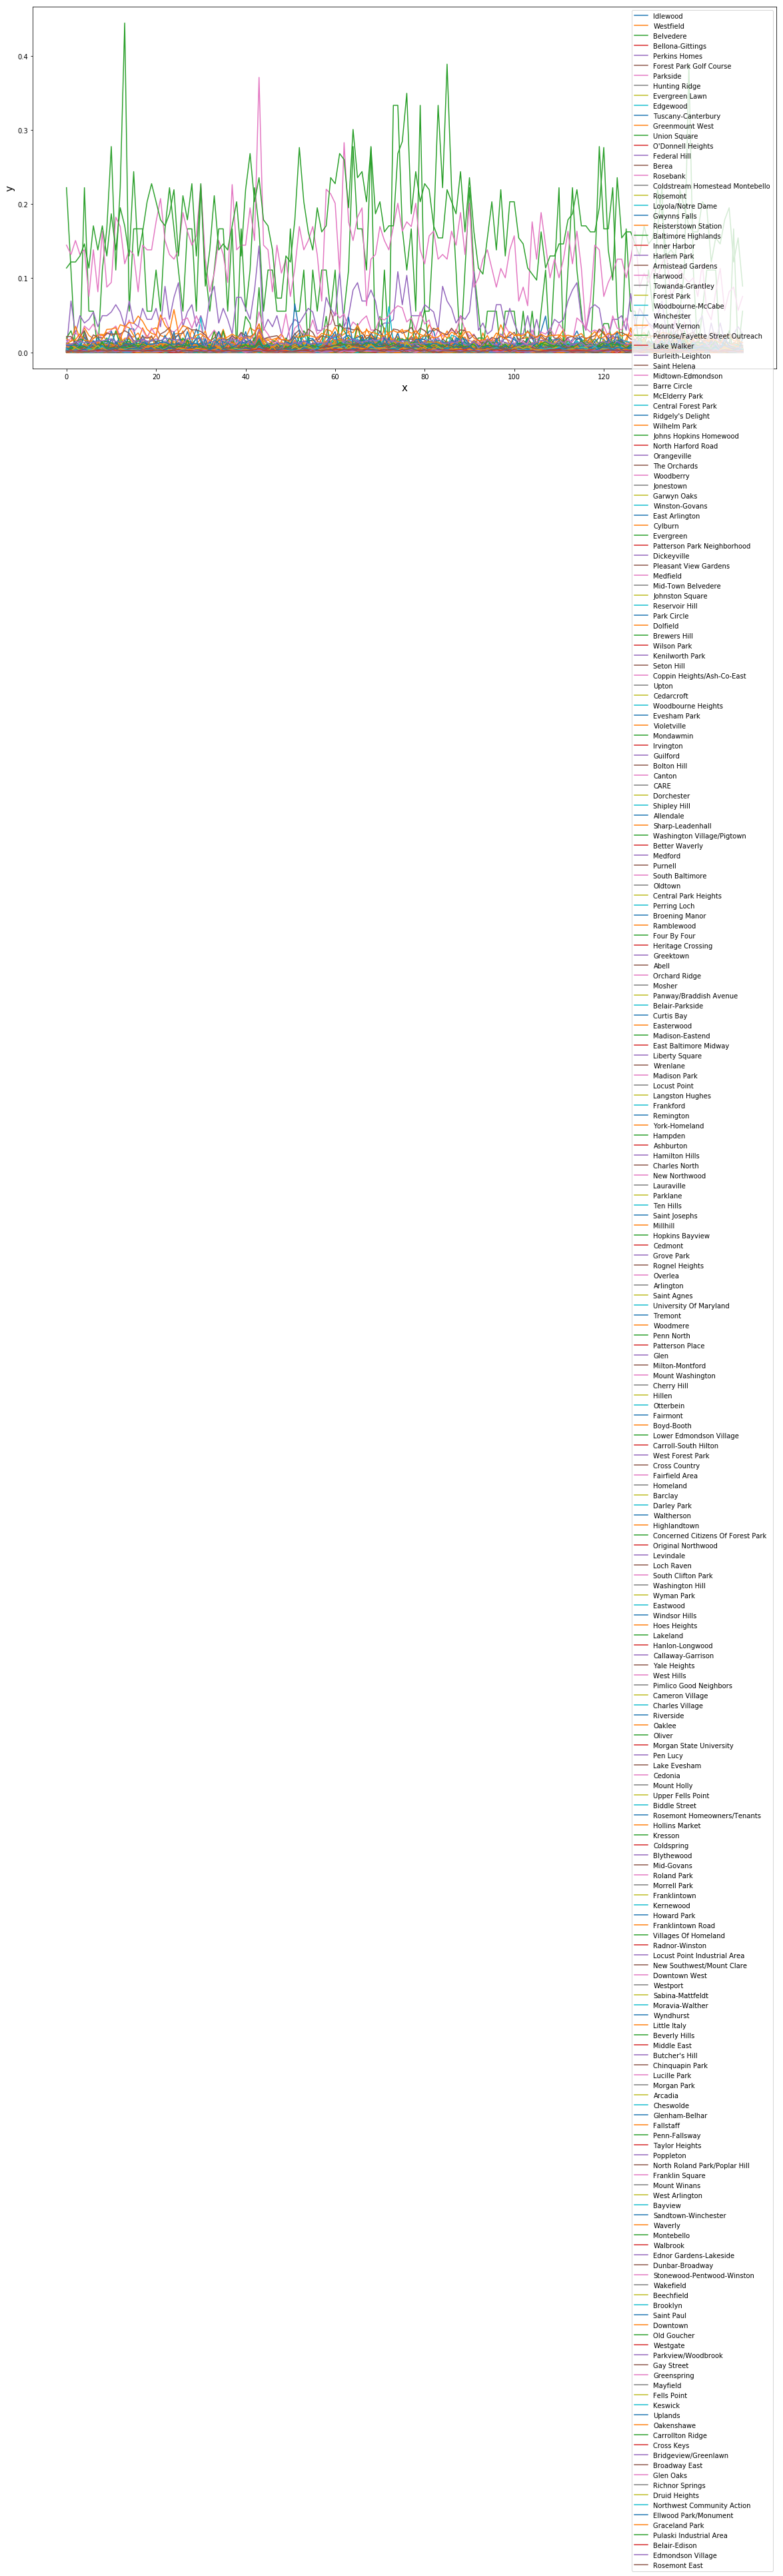

In [171]:
showTimeSeries(tsDict)

In [172]:
with open('../../data/pickles/monthly_crime.pkl','wb') as pkl_file:
    pickle.dump(tsDict,pkl_file)

In [173]:
import itertools
import warnings

In [174]:
def correlateTS(tsDict):
    n = len(tsDict.keys())
    corrMat = np.zeros((n,n))
    region2index = {i:j for i,j in zip(tsDict.keys(),range(n))}
    
    for a,b in itertools.combinations(tsDict.keys(), 2):
        tsa,tsb = tsDict[a],tsDict[b]
        
        with warnings.catch_warnings():
            warnings.filterwarnings('error')
            try:
                coeff = np.corrcoef(tsa,tsb)[0,1]
            except:
                coeff = 0
        corrMat[region2index[a]][region2index[b]] = float(coeff)
        if not a==b:
            corrMat[region2index[b]][region2index[a]] = float(coeff)
            
    return(corrMat,region2index)

In [175]:
corrMat,region2index = correlateTS(tsDict)

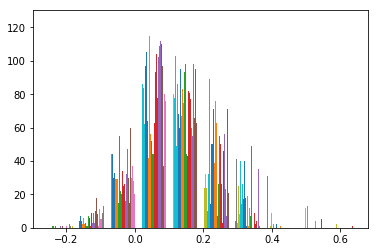

In [178]:
plt.hist(corrMat)
plt.show()

In [37]:
neighCounts = {}
regionCol = 'neighborhood'
for region in set(dframe[regionCol]):
    neighCounts[region] = len(dframe[dframe[regionCol]==region])

In [182]:
def normByPopulation(pops,dframe,regionCol):
    standardizedCrimes = {}
    for _,row in pops.iterrows():
        name,pop = row['name'],row['population']
        if pop==0:
            print('%s has a population of zero' % (name))
            continue
        dframe[dframe[regionCol]==name]
        try:
            standardizedCrimes[name] = len(dframe[dframe[regionCol]==name]) / pop
        except:
            print('%s failed' % name)
    mu = np.mean(list(standardizedCrimes.values()))
    std = np.std(list(standardizedCrimes.values()))
    normalizedCrime = {i:(j-mu)/std for i,j in standardizedCrimes.items()}
    
    return(pd.DataFrame(list(normalizedCrimes.items()),columns=['neighborhood','normalized_crime']))

In [183]:
normalizedCrimes = normByPopulation(populations,dframe,'neighborhood')

Canton Industrial Area has a population of zero
Carroll - Camden Industrial Area has a population of zero
Carroll Park has a population of zero
Clifton Park has a population of zero
Curtis Bay Industrial Area has a population of zero
Druid Hill Park has a population of zero
Dundalk Marine Terminal has a population of zero
Greenmount Cemetery has a population of zero
Gwynns Falls/Leakin Park has a population of zero
Hawkins Point has a population of zero
Herring Run Park has a population of zero
Holabird Industrial Park has a population of zero
Jones Falls Area has a population of zero
Lower Herring Run Park has a population of zero
Middle Branch/Reedbird Parks has a population of zero
Mt Pleasant Park has a population of zero
Orangeville Industrial Area has a population of zero
Patterson Park has a population of zero
Port Covington has a population of zero
Seton Business Park has a population of zero
Spring Garden Industrial Area has a population of zero
Stadium Area has a population o

In [184]:
with open('../../data/pickles/normalized_crimes.pkl','wb') as pkl_file:
    pickle.dump(normalizedCrimes,pkl_file)

In [185]:
normalizedCrimes.to_csv(r'../../data/pickles/normalized_crimes.csv')

In [ ]:
standarizedCrimes = pickle.load(open('../../data/pickles/standardized_crimes.pkl','rb'))
normalizedCrimes.to_csv(r'../../data/pickles/normalized_crimes.csv')